# Investigating GW x Galaxy cross-correlations

In this notebook, we will attempt to reproduce the results obtained in [this paper](https://arxiv.org/abs/1603.02356).

In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from src.bias import GrowthRateBias
from src.camb_interface import CAMBInterface
from src.cosmology import Cosmology
from src.density import UniformInVolumeNumberDensity, RadialBin
from src.kernel import ClusteringKernel, WeakLensingKernel
from src.tracer import Tracer
from src.power import Power
from src.window import BoxWindowFunction, GWClusteringWindowFunction

We fix the fiducial cosmology with parameters from Planck 2018. We compute the matter power spectrum with `CAMB`:

Note: redshifts have been re-sorted (earliest first)


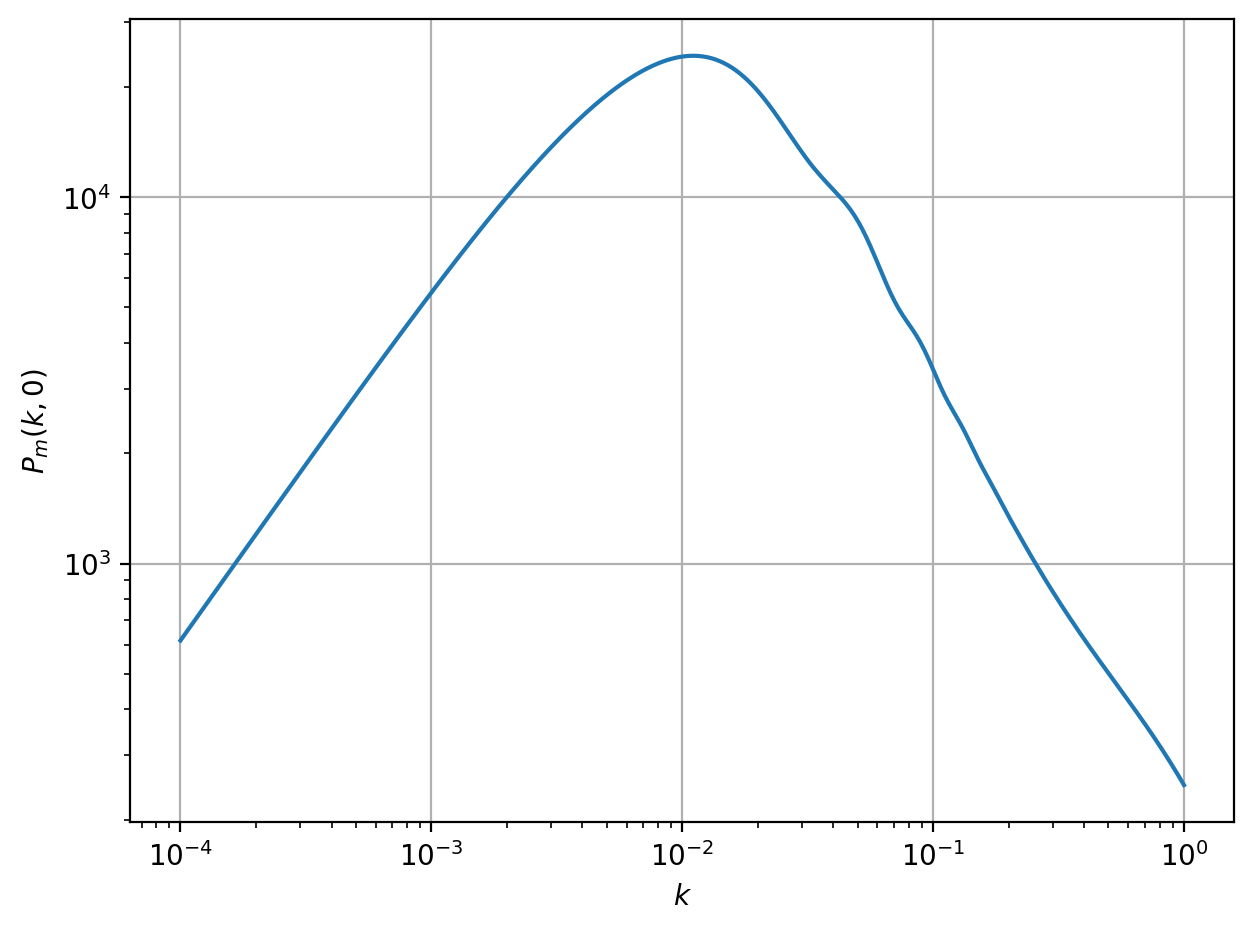

In [2]:
zmin = 1e-4
zmax = 1.4
npoints = 500
z = np.linspace(zmin, zmax, npoints)
k = np.logspace(-4, 0, npoints)
camb_interface = CAMBInterface(zmin, zmax)
camb_interface.run_solver()
cosmology = Cosmology(camb_interface)
pm = cosmology.matter_power_spectrum_interpolator().P

fig, ax = plt.subplots()
ax.plot(k, pm(0, k))
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$P_m(k, 0)$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid()
fig.tight_layout()
plt.show()

Below we fix the GW bin to $z \in [0.9, 1.1]$ and we define multiple galaxy bins $z_i \in [z^g_i - 0.05, z^g_i + 0.05]$ for an array of $z^g_i \in [0.01, 1.3]$. This is the setup for Figure 1 of the paper.

In [3]:
def galaxy_bin(zg, delta_z):
    return RadialBin(zg - 0.5 * delta_z, zg + 0.5 * delta_z)

nbins = 50
zg_arr = np.linspace(0.01, 1.3, nbins)
g_bins = [galaxy_bin(zg, 0.1) for zg in zg_arr]
gw_bin = RadialBin(0.9, 1.1)

To define both tracers, we specify their number densities, kernels and the respective bias dependence with redshift.

In [7]:
g_density = UniformInVolumeNumberDensity(1e-3, cosmology)
gw_density = UniformInVolumeNumberDensity(3e-6, cosmology)

g_kernels = [ClusteringKernel('galaxy clustering', 'g')]
gw_kernels = [
    ClusteringKernel('gw clustering', 's'),
    WeakLensingKernel('gw lensing', 't')
    ]

g_window_function = BoxWindowFunction()
gw_window_function = GWClusteringWindowFunction(cosmology, 0.05)

g_bias = GrowthRateBias(cosmology)
gw_bias = GrowthRateBias(cosmology)

g_tracer = Tracer(g_density, g_kernels, g_window_function, g_bias)
gw_tracer = Tracer(gw_density, gw_kernels, gw_window_function, gw_bias)

In the plots below, we inspect the number density convolved with the window function for each tracer bin, i.e

$$ n^X_i(z) = \int_0^{\infty} W^X_i(z') n^x(z')dz'$$

Since the window functions have little support for $z>1.4$, we restrict all integrals to $z \in [0,1.4]$.

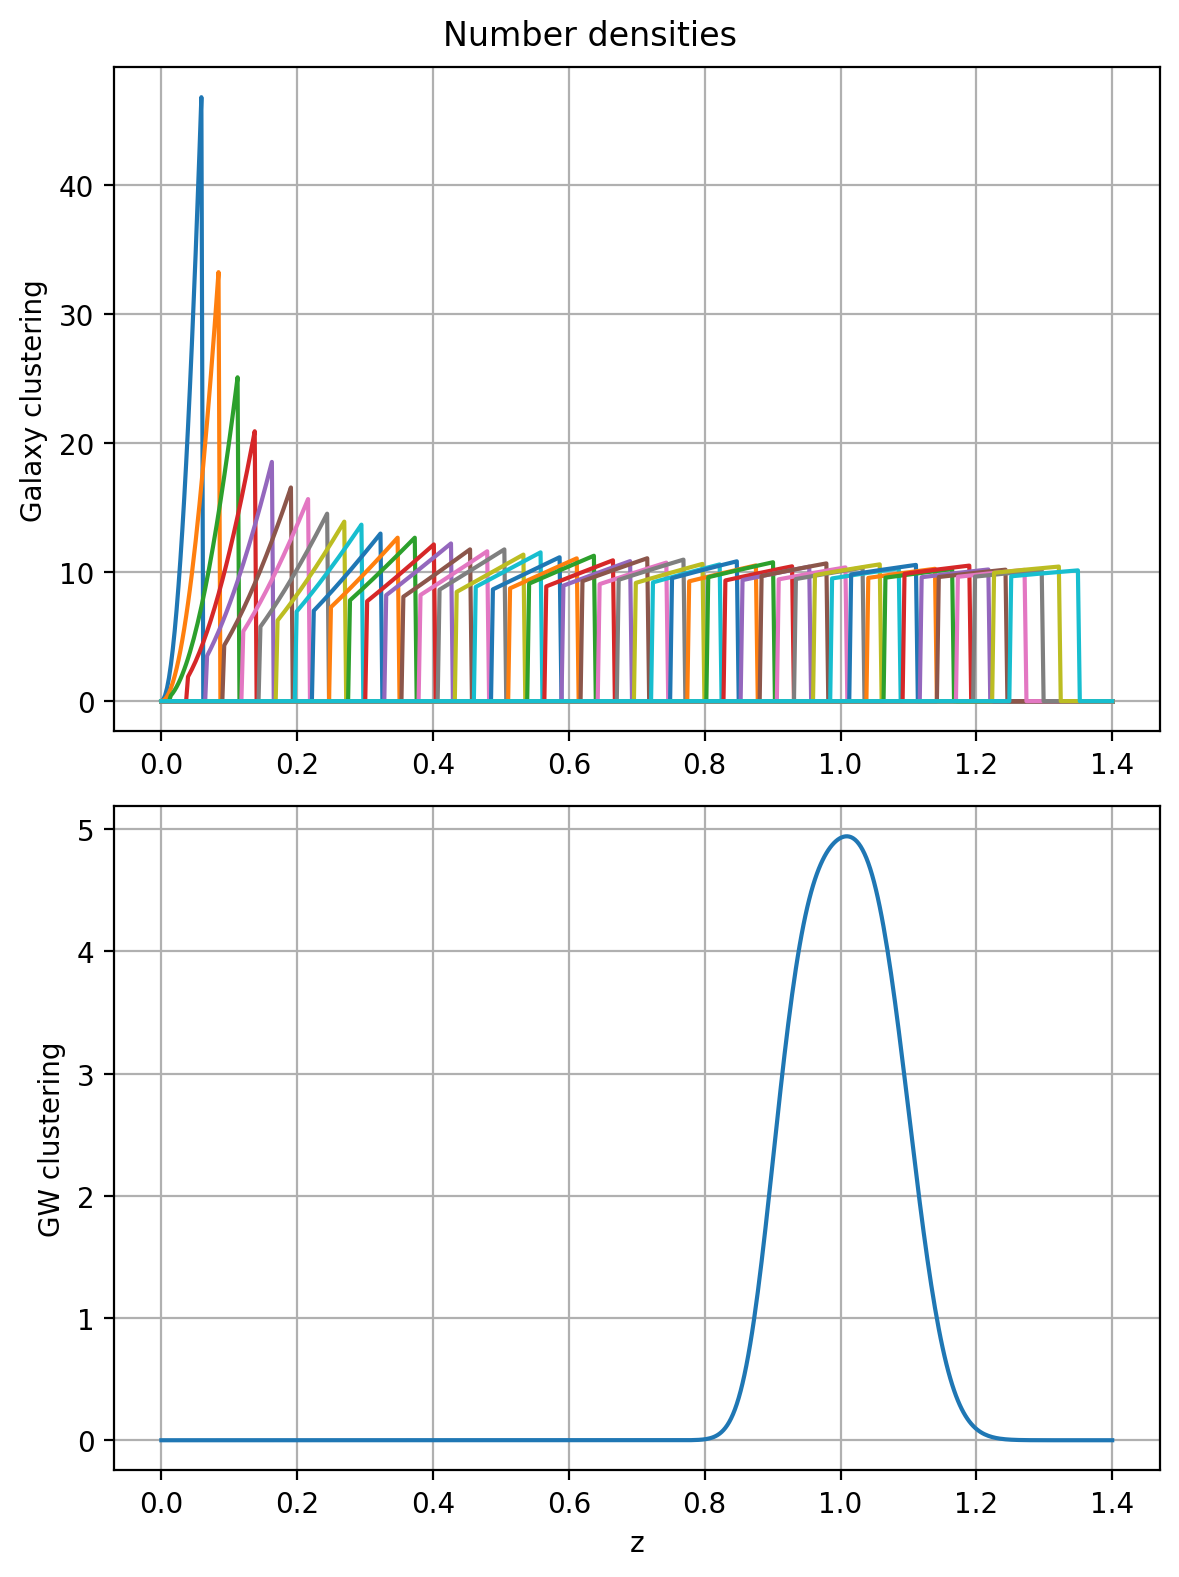

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))
for i, zbin in enumerate(g_bins):
    ng = g_tracer.normalized_density(zbin, z)
    ax1.plot(z, ng, label=f'Bin {i + 1}')

ns = gw_tracer.normalized_density(gw_bin, z)
ax2.plot(z, ns)

ax1.grid()
ax2.grid()
ax1.set_ylabel('Galaxy clustering')
ax2.set_ylabel('GW clustering')
#ax1.legend()
ax2.set_xlabel('z')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
fig.suptitle('Number densities')
plt.show()

Computing the galaxy and GW kernels that enter the $C_\ell$ computation as

$$ C^{XY,ij}_\ell = \int_0^{\infty} \frac{W^X_i(z)W^Y_j(z)}{H(z) \chi^2(z)} P_m \left(\frac{\ell + 1/2}{\chi(z)}, z \right)dz.$$

Note the use of Limber's approximation to avoid the integration over wavenumbers.

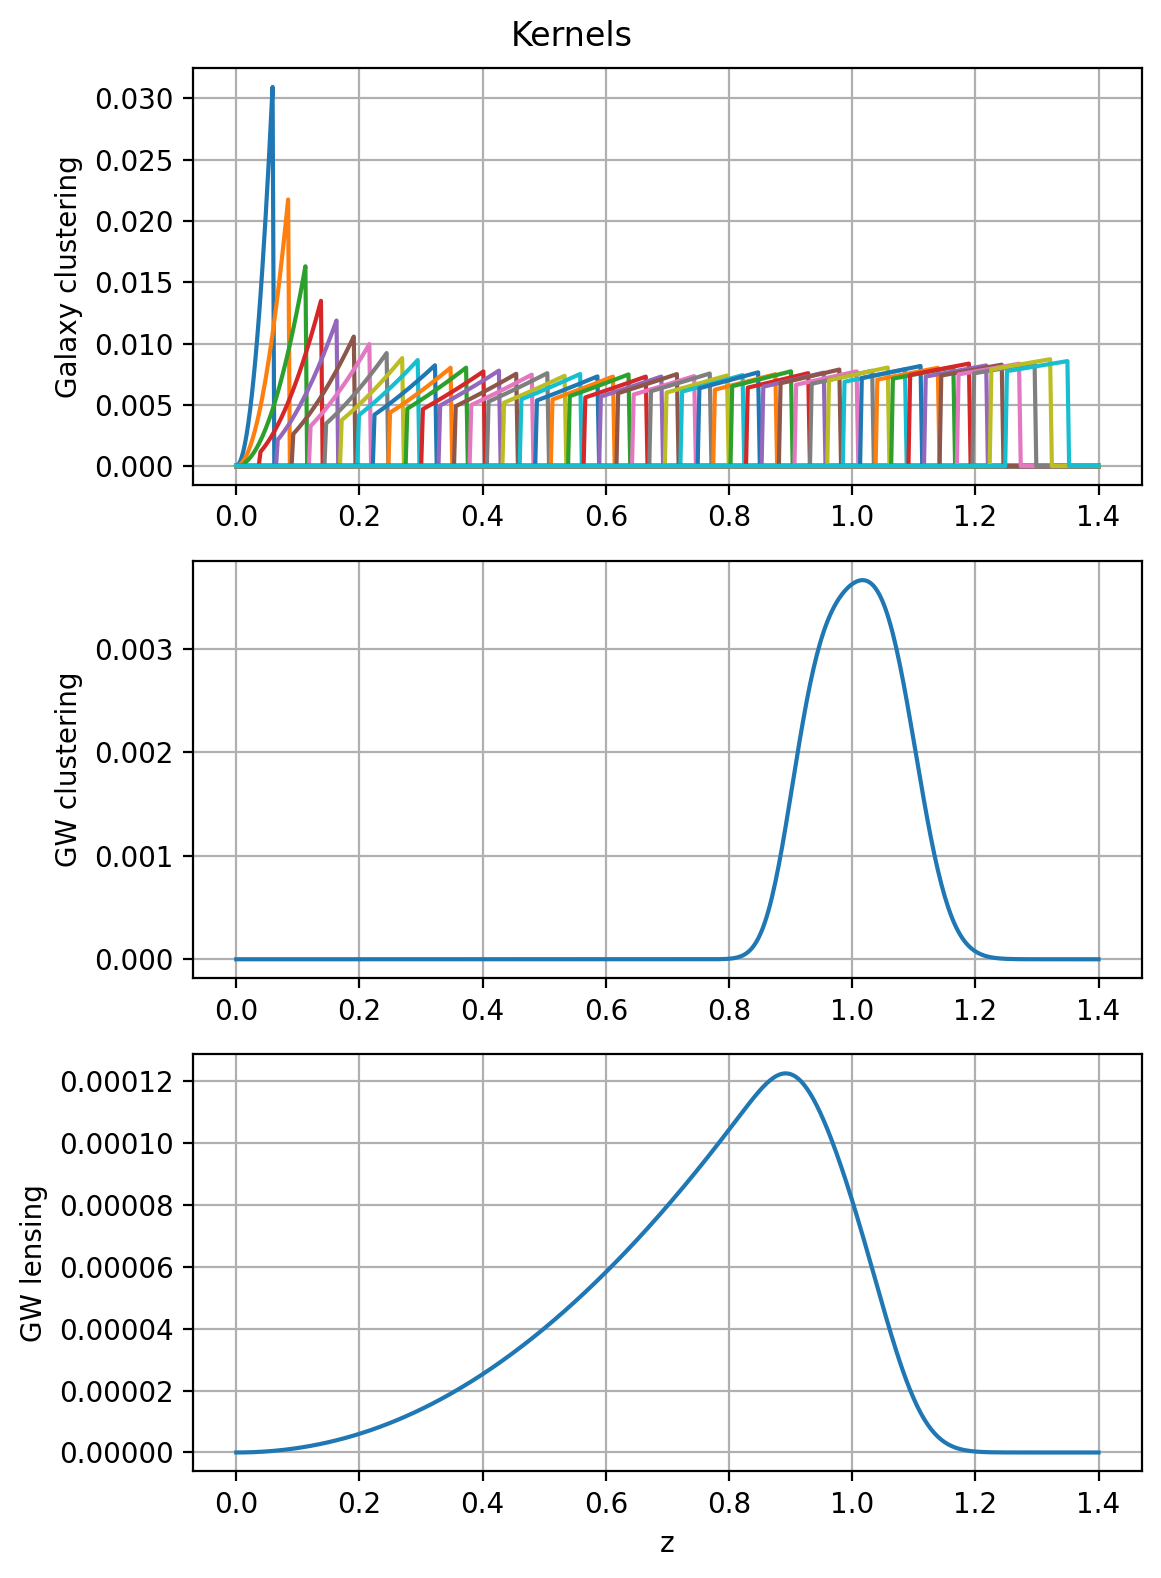

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 8))
for i, zbin in enumerate(g_bins):
    kernel = g_tracer.compute_kernel_functions(zbin, cosmology, z)
    ax1.plot(z, kernel[0, :], label=f'Bin {i + 1}')

gw_kernel = gw_tracer.compute_kernel_functions(gw_bin, cosmology, z)
ax2.plot(z, gw_kernel[0, :])
ax3.plot(z, gw_kernel[1, :])

ax1.grid()
ax2.grid()
ax3.grid()
ax1.set_ylabel('Galaxy clustering')
ax2.set_ylabel('GW clustering')
ax3.set_ylabel('GW lensing')
#ax1.legend()
ax3.set_xlabel('z')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
fig.suptitle('Kernels')
plt.show()

Computing power spectra:

In [10]:
cp = Power(cosmology)
l = 100
cls = np.empty((nbins, g_tracer.nkernels, gw_tracer.nkernels))
for i, g_bin in enumerate(g_bins):
    cls[i, :, :]= cp.cls(l, g_tracer, gw_tracer, g_bin, gw_bin, z)

Plotting results:

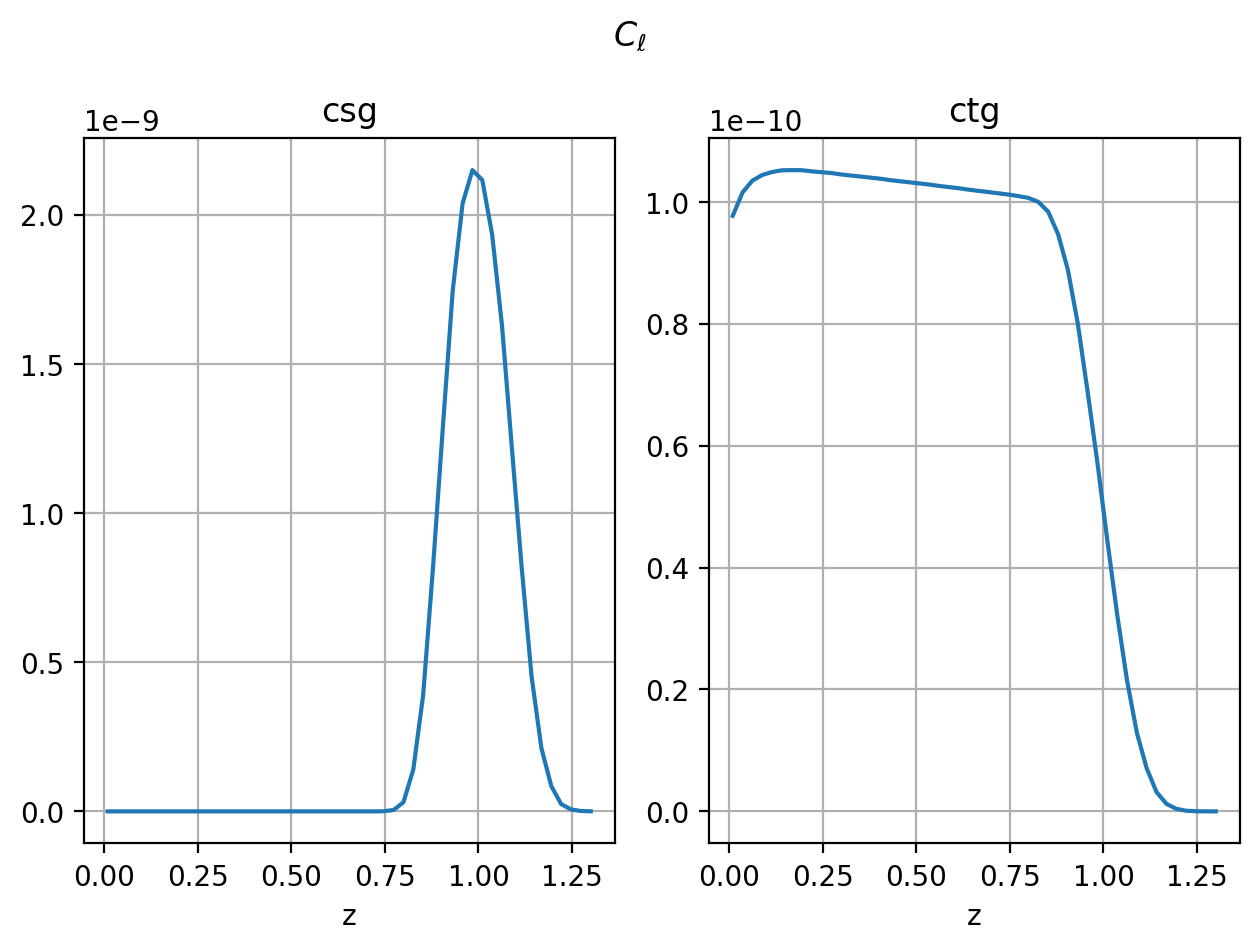

In [11]:
fig, axs = plt.subplots(g_tracer.nkernels, gw_tracer.nkernels, squeeze=False)
binvec = np.arange(nbins)
labels = [
    [f'c{k2.symbol}{k1.symbol}' for k2 in gw_tracer.kernels]
    for k1 in g_tracer.kernels
]
for i in range(g_tracer.nkernels):
    for j in range(gw_tracer.nkernels):
        axs[i][j].plot(zg_arr, cls[:, i, j])
        axs[i][j].set_xlabel('z')
        axs[i][j].set_title(labels[i][j])
        axs[i][j].grid()

fig.subplots_adjust(top=0.95)
fig.suptitle(r'$C_\ell$')
fig.tight_layout()
plt.show()

Log plots:

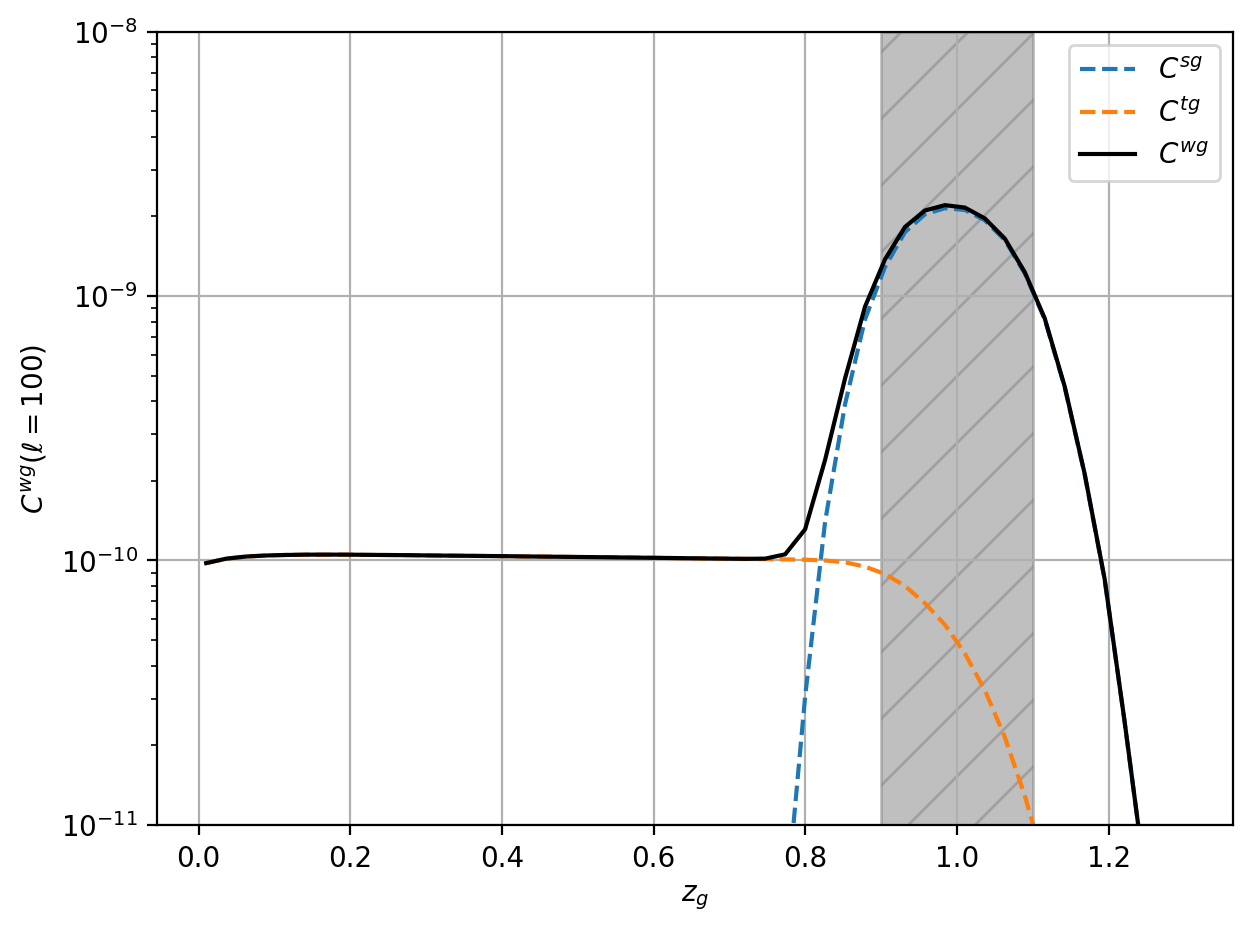

In [12]:
fig, ax = plt.subplots()
binvec = np.arange(nbins)
labels = [
    [r'$C^{{{0}{1}}}$'.format(k2.symbol, k1.symbol) for k2 in gw_tracer.kernels]
    for k1 in g_tracer.kernels
]
for i in range(g_tracer.nkernels):
    for j in range(gw_tracer.nkernels):
        ax.semilogy(zg_arr, cls[:, i, j], '--', label=labels[i][j])

full_cls = np.sum(cls, axis=(-2, -1))      
ax.semilogy(zg_arr, full_cls, color='k', label=r'$C^{wg}$')
ax_lims = np.linspace(1e-11, 1e-8)
ax.fill_betweenx(ax_lims, gw_bin.low, gw_bin.high, color='grey', alpha=0.5, hatch='/') 

ax.set_xlabel('$z_g$')
ax.set_ylabel(r'$C^{wg}' + r'(\ell={0})$'.format(l))
ax.grid()
ax.legend(loc='best')
ax.set_ylim([ax_lims[0], ax_lims[-1]])
fig.tight_layout()
plt.show()